In [47]:
import torch

import numpy as np
from pymc import InverseGamma

from sbi.analysis import pairplot
from sbi.inference import NPE,NLE

from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from torch.distributions import Normal, Independent,InverseGamma

In [48]:
num_dim = 1  # 这里的 num_dim = 2，表示我们有两个参数 μ 和 σ

# 定义模拟器函数
# torch.randn：生成一个服从标准正态分布（即均值为 0，标准差为 1）的随机数。

def simulator(theta, n=1000):
    # theta[0] 是 μ, theta[1] 是 σ
    mu, sigma2 = 0,theta[0]
    sigma = np.sqrt(sigma2)
    return mu + sigma * torch.randn(n)  # 生成 n 组观测数据


In [49]:
# 包装成具有明确 event_shape 的分布
prior = Independent(InverseGamma(torch.tensor([2.0]), torch.tensor([1.0])), 1)


In [50]:
# 验证 sample 的形状
sample = prior.sample((10,))  # 批量采样 10 个
print("Sample shape:", sample.shape)

Sample shape: torch.Size([10, 1])


In [51]:
prior, num_parameters, prior_returns_numpy = process_prior(prior)
# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)
# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

In [52]:
inference = NLE(prior=prior)

# 生成模拟数据
num_simulations = 500
theta = prior.sample((num_simulations,))
x = simulator(theta)

# 打印检查
print("theta.shape", theta.shape)
print("x.shape", x.shape)

theta.shape torch.Size([500, 1])
x.shape torch.Size([500, 1000])


In [53]:
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()

 Neural network successfully converged after 145 epochs.

In [54]:
posterior = inference.build_posterior(density_estimator)

/opt/anaconda3/envs/SBI_project/lib/python3.11/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


In [55]:
# # 手动设置 theta 的真实值
theta_true = torch.tensor([[0.3]])  # μ = 1.0
x_obs = simulator(theta_true)
samples = posterior.sample((10000,), x=x_obs)


Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

In [56]:
import numpy as np

# 先验参数
alpha_0 = 2
beta_0 = 1  # 先验方差

# 数据准备
Z = x_obs.numpy()  # 如果是 PyTorch 张量，转换为 NumPy 数组
Z_flat = Z.flatten()  # 展平成一维数组

# 样本均值和样本数量
Y_mean = np.mean(Z_flat)  # 样本均值
n = Z.size  # 样本数量

# 计算样本的总方差
variance = np.sum((Z_flat - Y_mean) ** 2) 

# 后验均值 μ'
alpha_poster = alpha_0 + n / 2
beta_poster = beta_0 + variance / 2 

# 输出结果
print("Posterior alpha:", alpha_poster)
print("Posterior beta:", beta_poster)


Posterior alpha: 502.0
Posterior beta: 150.27203369140625


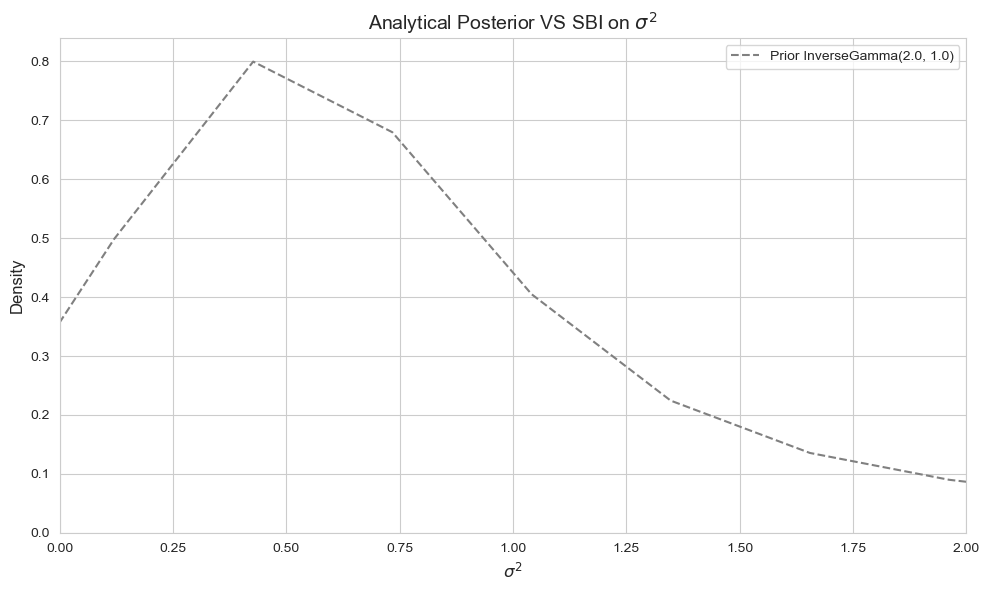

In [57]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 alpha_poster 和 beta_poster 已经定义
alpha_prior = 2.0  # Inverse Gamma 形状参数 α
beta_prior = 1.0   # Inverse Gamma 率参数 β

# 从 Inverse Gamma 分布中采样
# 逆伽马分布样本通过伽马分布样本的倒数生成
gamma_samples = np.random.gamma(shape=alpha_prior, scale=1 / beta_prior, size=10000)
inverse_gamma_samples = 1 / gamma_samples  # 转换为逆伽马分布样本

# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

# 使用 seaborn 绘制逆伽马分布的 KDE 图
sns.kdeplot(inverse_gamma_samples, ax=ax,  label=f"Prior InverseGamma({alpha_prior}, {beta_prior})", color="grey",linestyle="--")

# 添加图例、标题和标签
ax.set_title("Analytical Posterior VS SBI on $\sigma^2$", fontsize=14)
ax.set_xlabel(r"$\sigma^2$", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# 设置 x 轴范围
ax.set_xlim(0, 2)

# 显示图形
plt.tight_layout()
plt.show()

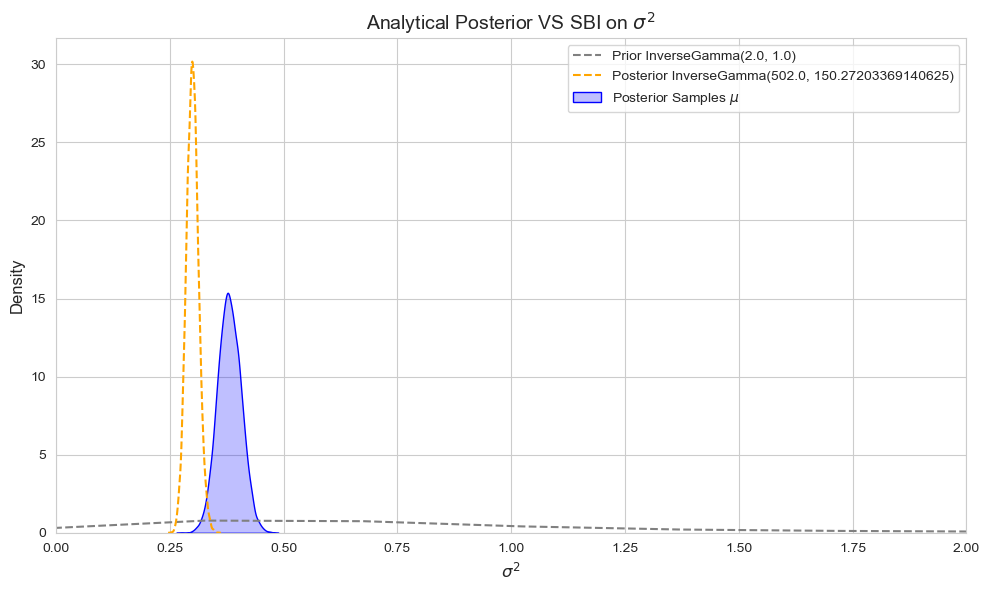

In [58]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 alpha_poster 和 beta_poster 已经定义
alpha_prior = 2.0  # Inverse Gamma 形状参数 α
beta_prior = 1.0   # Inverse Gamma 率参数 β

# 从 Inverse Gamma 分布中采样
# 逆伽马分布样本通过伽马分布样本的倒数生成
gamma_samples = np.random.gamma(shape=alpha_prior, scale=1 / beta_prior, size=10000)
inverse_gamma_samples = 1 / gamma_samples  # 转换为逆伽马分布样本

# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

# 使用 seaborn 绘制逆伽马分布的 KDE 图
sns.kdeplot(inverse_gamma_samples, ax=ax, label=f"Prior InverseGamma({alpha_prior}, {beta_prior})", color="grey",linestyle="--")

gamma_samples = np.random.gamma(shape=alpha_poster, scale=1 / beta_poster, size=10000)
inverse_gamma_samples = 1 / gamma_samples 
sns.kdeplot(inverse_gamma_samples, ax=ax,  label=f"Posterior InverseGamma({alpha_poster}, {beta_poster})", color="orange",linestyle="--")

mu_samples = samples[:, 0].numpy()  # 提取样本的第一个维度（例如 $\mu$）
sns.kdeplot(mu_samples, ax=ax, fill=True, label=r"Posterior Samples $\mu$", color="blue")

# 添加图例、标题和标签
ax.set_title("Analytical Posterior VS SBI on $\sigma^2$", fontsize=14)
ax.set_xlabel(r"$\sigma^2$", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# 设置 x 轴范围
ax.set_xlim(0, 2)

# 显示图形
plt.tight_layout()
plt.show()


In [59]:
# # 手动设置 theta 的真实值
theta_true = torch.tensor([[1]])  # μ = 1.0
x_obs = simulator(theta_true)
samples = posterior.sample((10000,), x=x_obs)


Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

In [60]:
import numpy as np

# 先验参数
alpha_0 = 2
beta_0 = 1  # 先验方差

# 数据准备
Z = x_obs.numpy()  # 如果是 PyTorch 张量，转换为 NumPy 数组
Z_flat = Z.flatten()  # 展平成一维数组

# 样本均值和样本数量
Y_mean = np.mean(Z_flat)  # 样本均值
n = Z.size  # 样本数量

# 计算样本的总方差
variance = np.sum((Z_flat - Y_mean) ** 2) 

# 后验均值 μ'
alpha_poster = alpha_0 + n / 2
beta_poster = beta_0 + variance / 2 

# 输出结果
print("Posterior alpha:", alpha_poster)
print("Posterior beta:", beta_poster)


Posterior alpha: 502.0
Posterior beta: 500.8975830078125


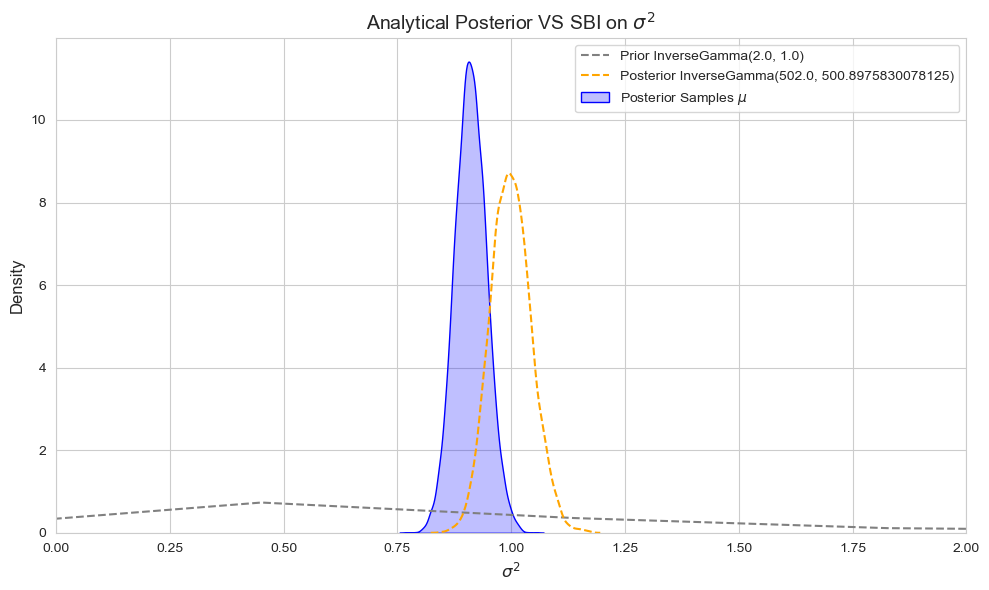

In [61]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 alpha_poster 和 beta_poster 已经定义
alpha_prior = 2.0  # Inverse Gamma 形状参数 α
beta_prior = 1.0   # Inverse Gamma 率参数 β

# 从 Inverse Gamma 分布中采样
# 逆伽马分布样本通过伽马分布样本的倒数生成
gamma_samples = np.random.gamma(shape=alpha_prior, scale=1 / beta_prior, size=10000)
inverse_gamma_samples = 1 / gamma_samples  # 转换为逆伽马分布样本

# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

# 使用 seaborn 绘制逆伽马分布的 KDE 图
sns.kdeplot(inverse_gamma_samples, ax=ax, label=f"Prior InverseGamma({alpha_prior}, {beta_prior})", color="grey",linestyle="--")

gamma_samples = np.random.gamma(shape=alpha_poster, scale=1 / beta_poster, size=10000)
inverse_gamma_samples = 1 / gamma_samples 
sns.kdeplot(inverse_gamma_samples, ax=ax,  label=f"Posterior InverseGamma({alpha_poster}, {beta_poster})", color="orange",linestyle="--")

mu_samples = samples[:, 0].numpy()  # 提取样本的第一个维度（例如 $\mu$）
sns.kdeplot(mu_samples, ax=ax, fill=True, label=r"Posterior Samples $\mu$", color="blue")

# 添加图例、标题和标签
ax.set_title("Analytical Posterior VS SBI on $\sigma^2$", fontsize=14)
ax.set_xlabel(r"$\sigma^2$", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# 设置 x 轴范围
ax.set_xlim(0, 2)

# 显示图形
plt.tight_layout()
plt.show()
